# Decision Tree Grid Search
Machine Learning Titanic. Currently, my decision tree scores top 6%. I scored top 5% using both random forest and xgBoost: 
* https://github.com/ScottySchmidt/Kaggle/blob/main/xgbTop5%25.ipynb
* https://github.com/ScottySchmidt/Kaggle/blob/main/Titanic.ipynb

Decision tree will initially score almost a perfect AUC but that is because the data overfits. Regularizing the decision tree will be key for a high score. GridSearch will tune all the best possible parameters to get the best solution possible.  

# Train Data
Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and whether they survive or not. The shape of the train data is (891, 12). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time
from math import sqrt

train=r'/kaggle/input/titanic/train.csv'
test=r'/kaggle/input/titanic/test.csv' 

df=pd.read_csv(train)
test=pd.read_csv(test)

print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#Check Duplicates:
dupstr = df.duplicated()
print('Total no of duplicate values in Training Dataset = %d' % (dupstr.sum()))
df[dupstr]

Total no of duplicate values in Training Dataset = 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [3]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
dtype: float64


# Feature Engineer
We need to replace male and female into numbers. This is a very important part of the process because gender is one of the highest predictors on if a person survived or not.

In [4]:
#GENDER
df['Sex']=df['Sex'].map({'female':0,'male':1})
df['Pclass'].value_counts()
df['FirstClass']=df['Pclass'].apply(lambda x: 1 if x==1 else 0)

Females whose number is 0 had a much higher chance of surving than males. Later on, doing the importance feature analysis we will view that gender is actually one of the highest predictors. 

In [5]:
genderTable = pd.crosstab(df['Survived'],df['Sex'])
genderTable

Sex,0,1
Survived,,
0,81,468
1,233,109


# Encode Categorical Variables
Encode Categorical Variables is needed for this dataset since there are many important variables that are not numeric yet. 

There are three classes C, Q, and S. Class C seems to have the highest chance of survival. Class S has the lowest chance of survival. Unfornately this would tend to show that economic status seems to played a part in the decision if someone survived or not. Embarked does not play role major role in feature importance. 

In [6]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['Embarked'])
#df = encoder.fit_transform(df)
#test = encoder.fit_transform(test)
#test.head()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstClass
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0


# Examine Target Variable
Survived is the Y variable we will be analyzing. Since the survival rete is 0.384 the data is not considered unbalanced. 

In [7]:
temp=df['Survived'].value_counts()
print(temp)
no=temp[0]
yes=temp[1]
percent=round(yes/(yes+no),3)
print("Percent that survived: ", percent)

0    549
1    342
Name: Survived, dtype: int64
Percent that survived:  0.384


# Numeric DataFrame
For now, we will analyze only numeric values. Categorical values will need to be encoded or analyzed individually.

In [8]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FirstClass
0,1,0,3,1,22.0,1,0,7.2500,0
1,2,1,1,0,38.0,1,0,71.2833,1
2,3,1,3,0,26.0,0,0,7.9250,0
3,4,1,1,0,35.0,1,0,53.1000,1
4,5,0,3,1,35.0,0,0,8.0500,0


# Correlations

<AxesSubplot:>

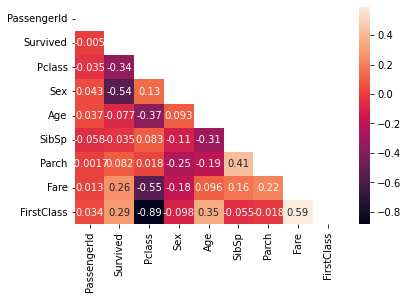

In [9]:
import seaborn as sns
corr= df.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)

# Check for missing values
Age is missing around 20% of values.Therefore, we can simply fill in the mean for that one column.

In [10]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Age            0.198653
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Sex            0.000000
dtype: float64


In [11]:
df= df.fillna(df.mean())

# Split Data

In [12]:
X=df.drop('Survived', axis=1)
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 42)

# Highly Correlated Features
There are no highly correlated variables above 80%. Therefore, we do not need to be concerned about removing variables that are too highly correlated. 

# Tunning Tree

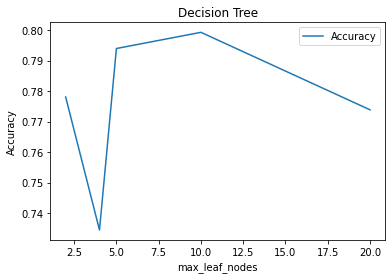

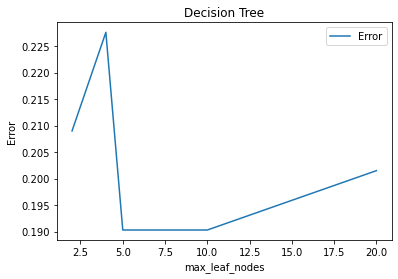

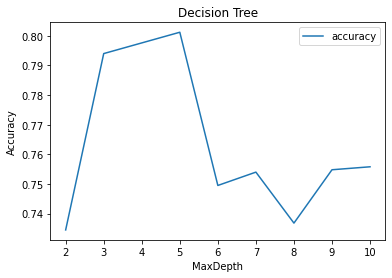

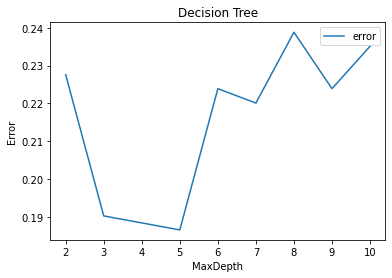

In [13]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    leafList = [None, 2, 4, 5, 10, 20]
    accList=[]
    maeList=[]
    
    for leaf in leafList:
        tree = DecisionTreeClassifier(max_leaf_nodes=leaf, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        accList.append(treeAUC)
        maeList.append(mae)
    
    plt.plot(leafList,accList, label="Accuracy")
    plt.title('Decision Tree')
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()         
    
    plt.plot(leafList, maeList, label="Error")
    plt.title('Decision Tree')
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('Error')
    plt.legend()
    plt.show()  
    
def calcDepth():
    maxDepthList = [2, 3, 5, 6, 7, 8, 9, 10]
    accList=[]
    maeList=[]
    
    for d in maxDepthList:
        tree = DecisionTreeClassifier(max_depth=d, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        maeList.append(mae)
        accList.append(treeAUC)
        #print(d, " max_depth || AUC ", treeAUC, " || MAE: ", mae)

    plt.plot(maxDepthList,accList, label="accuracy")
    plt.title('Decision Tree')
    plt.xlabel('MaxDepth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()         
    
    plt.plot(maxDepthList,maeList, label="error")
    plt.title('Decision Tree')
    plt.xlabel('MaxDepth')
    plt.ylabel('Error')
    plt.legend()
    plt.show()     
    
#TURN FUNCTION OFF OR ON BELOW:   
calcLeaf()
calcDepth() 

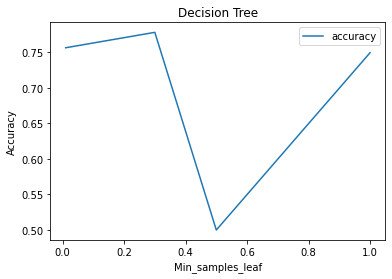

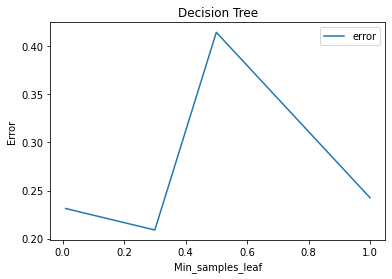

In [14]:
def minLeaf():
    numbers = [.01, .3, .5, 1]
    accList=[]
    maeList=[]
    
    for n in numbers:
        tree = DecisionTreeClassifier(min_samples_leaf=n, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        maeList.append(mae)
        accList.append(treeAUC)
        #print(d, " max_depth || AUC ", treeAUC, " || MAE: ", mae)

    plt.plot(numbers,accList, label="accuracy")
    plt.title('Decision Tree')
    plt.xlabel('Min_samples_leaf')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()         
    
    plt.plot(numbers,maeList, label="error")
    plt.title('Decision Tree')
    plt.xlabel('Min_samples_leaf')
    plt.ylabel('Error')
    plt.legend()
    plt.show()  
minLeaf()

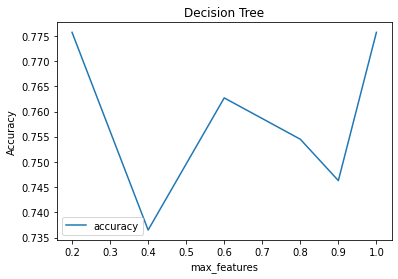

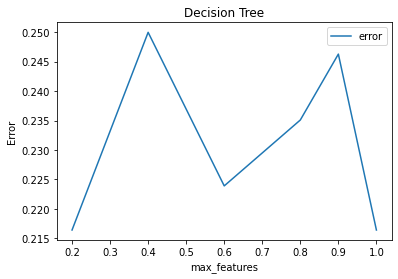

In [15]:
def maxFeat():
    name='max_features'
    numbers = [None, 0.2, 0.4, 0.6, 0.8, .9, 1]
    accList=[]
    maeList=[]

    for n in numbers:
        tree = DecisionTreeClassifier(max_features=n, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        maeList.append(mae)
        accList.append(treeAUC)
        #print(d, " max_depth || AUC ", treeAUC, " || MAE: ", mae)

    plt.plot(numbers,accList, label="accuracy")
    plt.title('Decision Tree')
    plt.xlabel(name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()         
    
    plt.plot(numbers,maeList, label="error")
    plt.title('Decision Tree')
    plt.xlabel(name)
    plt.ylabel('Error')
    plt.legend()
    plt.show()  
maxFeat()

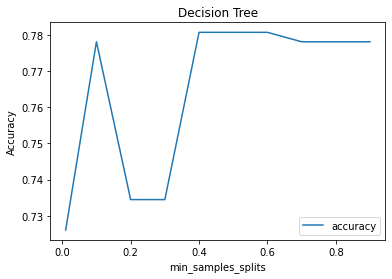

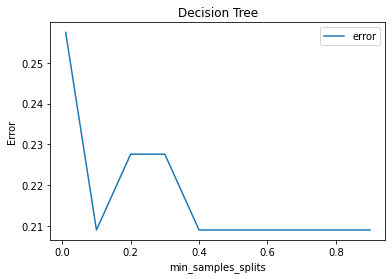

In [16]:
def minSplit():
    name='min_samples_splits'
    numbers = [.01, .1, .2, .3, .4, .5, .6, .7, .8, .9]
    accList=[]
    maeList=[]

    for n in numbers:
        tree = DecisionTreeClassifier(min_samples_split=n, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        maeList.append(mae)
        accList.append(treeAUC)
        #print(d, " max_depth || AUC ", treeAUC, " || MAE: ", mae)

    plt.plot(numbers,accList, label="accuracy")
    plt.title('Decision Tree')
    plt.xlabel(name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()         
    
    plt.plot(numbers,maeList, label="error")
    plt.title('Decision Tree')
    plt.xlabel(name)
    plt.ylabel('Error')
    plt.legend()
    plt.show()  
minSplit()

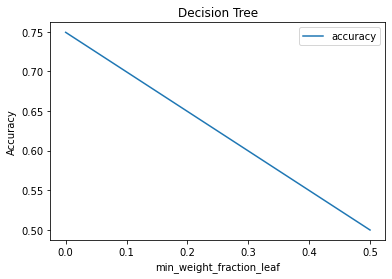

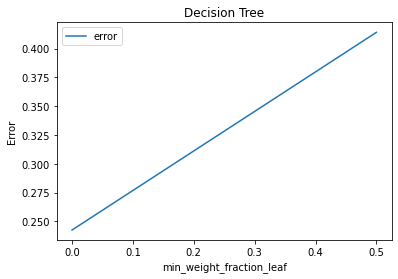

In [17]:
def minWeight():
    name='min_weight_fraction_leaf'
    numbers =[0, 0.5]
    accList=[]
    maeList=[]

    for n in numbers:
        tree = DecisionTreeClassifier(min_weight_fraction_leaf=n, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        maeList.append(mae)
        accList.append(treeAUC)
        #print(d, " max_depth || AUC ", treeAUC, " || MAE: ", mae)

    plt.plot(numbers,accList, label="accuracy")
    plt.title('Decision Tree')
    plt.xlabel(name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()         
    
    plt.plot(numbers,maeList, label="error")
    plt.title('Decision Tree')
    plt.xlabel(name)
    plt.ylabel('Error')
    plt.legend()
    plt.show()  
minWeight()

# GridSearch Tree
Using entropy versus gini makes little difference see notes page at end for more information. 
* Top 6% DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=0.9,
                 min_samples_leaf=0.01, min_samples_split=0.1)
* Top 10%  DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=0.5,
                       min_samples_leaf=0.01)
* Top 9%  DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features=0.9,
                       min_samples_leaf=0.01)
                       
Shockingly using max_depth of 6 scores slightly higher than max_depth 5 even though the individual tests show that max_depth 5 is better. Max_depth of 6 does not cross validate as well but it provides less error. Adding a min_samples_leaf gets close to a top 5%.

Using accuracy as a scoring metric performs better than neg_mean_absolute_error.

In [18]:
print("Start decision tree calculations:")
tree_param = {'criterion':['entropy', 'gini'],
            'max_depth':[4, 5],
             'max_leaf_nodes':[None, 2, 3], 
              'min_samples_leaf':[.01, .3, .5, 1],
            'max_features':[.1, .2, .3, .5, .7, .9, 1],
              'min_samples_split':[.01, .1, .2, .4],
              'min_weight_fraction_leaf':[0, .5],
             }
treeGrid=GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5, scoring='accuracy')
treeGrid.fit(X, y)
print(treeGrid.best_estimator_)

Start decision tree calculations:
DecisionTreeClassifier(max_depth=5, max_features=0.9, min_samples_leaf=0.01,
                       min_samples_split=0.01, min_weight_fraction_leaf=0)


#### Final Decision Tree Prediction
Inputs below such as best_depth by using functions above.

In [19]:
dtree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=4, 
    max_features=.5,
    max_leaf_nodes=None,
    min_samples_leaf=.01,
    min_samples_split=.01,
)

#FIT AND PREDICT:
dtree.fit(X, y)
y_pred =  dtree.predict(X_test)

#Calculate Metrics:
treeR2 = r2_score(y_test, y_pred).round(4)
treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for decision tree is: ", treeAUC)

treeMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(round(treeMSE, 4), " is tree MSE ")

#Cross Validate:
treeScore = dtree.score(X_test, y_test).round(4)  
treeCV = cross_validate(dtree, X, y, cv = 5)
treeCV=treeCV['test_score'].mean().round(4)
print(treeCV, ' || ', treeScore)
print(treeScore-treeCV, " cross validate score")

AUC for decision tree is:  0.7938
0.4276  is tree MSE 
0.7822  ||  0.8172
0.03500000000000003  cross validate score


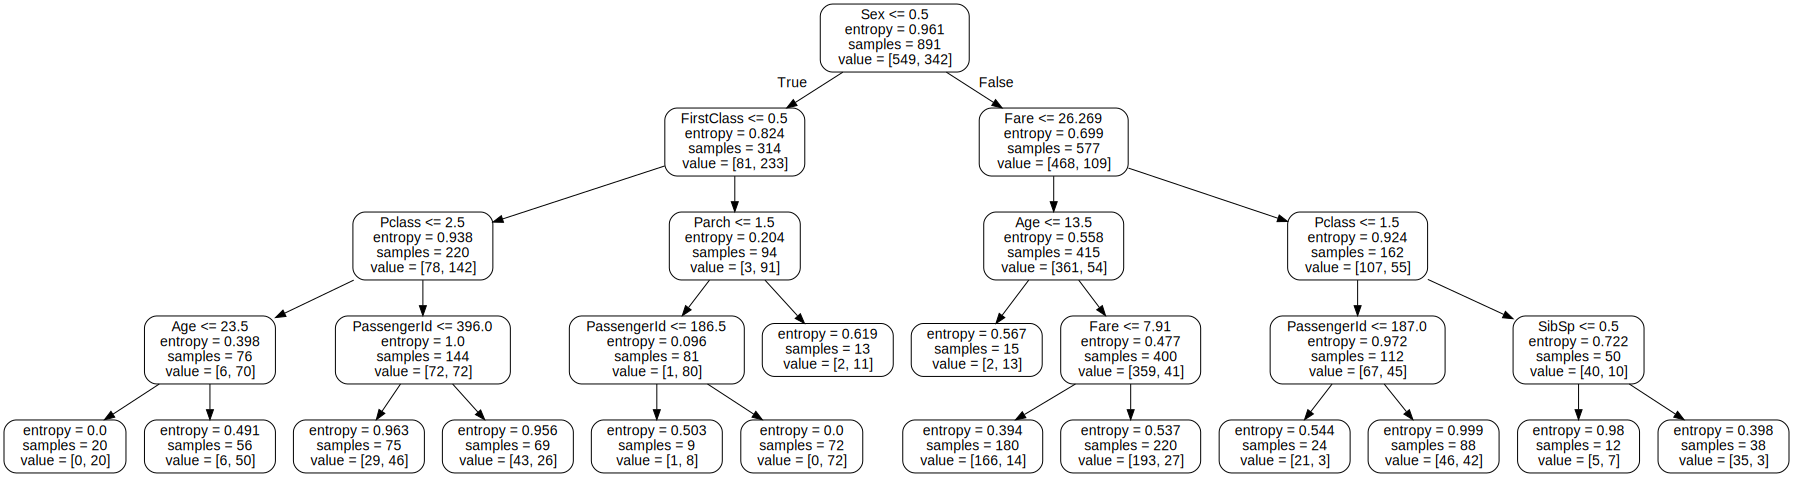

In [20]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(dtree, feature_names=X_train.columns, rounded=True)
graph = graphviz.Source(dot_data) 
graph

# Test Data

In [21]:
#GENDER
test['Sex']=test['Sex'].map({'female':0,'male':1})
test['FirstClass']=test['Pclass'].apply(lambda x: 1 if x==1 else 0)

features=list(X.columns)
test=test[features]

test=test.fillna(test.mean())
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,FirstClass
0,892,3,1,34.5,0,0,7.8292,0
1,893,3,0,47.0,1,0,7.0000,0
2,894,2,1,62.0,0,0,9.6875,0
3,895,3,1,27.0,0,0,8.6625,0
4,896,3,0,22.0,1,1,12.2875,0


# Final Prediction

In [22]:
test_predictions = dtree.predict(test)
passID=test['PassengerId']
tupleData = list(zip(passID, test_predictions))
output = pd.DataFrame(tupleData, columns = ['PassengerId', 'Survived'])
output.head(7)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0


In [23]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Notes:
#### Feature Engineer
Being a wife makes no difference in the final prediction: <br>
` df['Titles'] = df['Name'].str.extract(r', (\w+\.)') 
df['Titles'] = df['Titles'].apply(lambda x: 1 if x=='Mrs.' else 0) `

##### Gini vs. Entropy
Generally, your performance will not change whether you use Gini impurity or Entropy. Laura Elena Raileanu and Kilian Stoffel compared both in "Theoretical comparison between the gini index and information gain criteria". The most important remarks were:

It only matters in 2% of the cases whether you use gini impurity or entropy.
Entropy might be a little slower to compute (because it makes use of the logarithm).
I was once told that both metrics exist because they emerged in different disciplines of science.
https://datascience.stackexchange.com/questions/10228/when-should-i-use-gini-impurity-as-opposed-to-information-gain-entropy